## 1. Exploración de Datos (EDA)


In [17]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Cargar el dataset
df = pd.read_csv('US_Accidents.csv')

In [18]:
df.head()

,ID,Severity,Start_Time,End_Time,Start_Lat,Start_Lng,End_Lat,End_Lng,Distance(mi),Description,...,Roundabout,Station,Stop,Traffic_Calming,Traffic_Signal,Turning_Loop,Sunrise_Sunset,Civil_Twilight,Nautical_Twilight,Astronomical_Twilight
0,A-2716600,3,08-02-2016 00:37,08-02-2016 06:37,40.10891,-83.09286,40.11206,-83.03187,3.230,Between Sawmill Rd/Exit 20 and OH-315/Olentang...,...,False,False,False,False,False,False,Night,Night,Night,Night
1,A-2716601,2,08-02-2016 05:56,08-02-2016 11:56,39.86542,-84.06280,39.86501,-84.04873,0.747,At OH-4/OH-235/Exit 41 - Accident.,...,False,False,False,False,False,False,Night,Night,Night,Night
2,A-2716602,2,08-02-2016 06:15,08-02-2016 12:15,39.10266,-84.52468,39.10209,-84.52396,0.055,At I-71/US-50/Exit 1 - Accident.,...,False,False,False,False,False,False,Night,Night,Night,Day
3,A-2716603,2,08-02-2016 06:15,08-02-2016 12:15,39.10148,-84.52341,39.09841,-84.52241,0.219,At I-71/US-50/Exit 1 - Accident.,...,False,False,False,False,False,False,Night,Night,Night,Day
4,A-2716604,2,08-02-2016 06:51,08-02-2016 12:51,41.06213,-81.53784,41.06217,-81.53547,0.123,At Dart Ave/Exit 21 - Accident.,...,False,False,False,False,False,False,Night,Night,Day,Day


In [19]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1048575 entries, 0 to 1048574
Data columns (total 47 columns):
 #   Column                 Non-Null Count    Dtype  
---  ------                 --------------    -----  
 0   ID                     1048575 non-null  object 
 1   Severity               1048575 non-null  int64  
 2   Start_Time             1048575 non-null  object 
 3   End_Time               1048575 non-null  object 
 4   Start_Lat              1048575 non-null  float64
 5   Start_Lng              1048575 non-null  float64
 6   End_Lat                1048575 non-null  float64
 7   End_Lng                1048575 non-null  float64
 8   Distance(mi)           1048575 non-null  float64
 9   Description            1048575 non-null  object 
 10  Number                 360065 non-null   float64
 11  Street                 1048575 non-null  object 
 12  Side                   1048575 non-null  object 
 13  City                   1048506 non-null  object 
 14  County            

In [20]:
df.describe()

,Severity,Start_Lat,Start_Lng,End_Lat,End_Lng,Distance(mi),Number,Temperature(F),Wind_Chill(F),Humidity(%),Pressure(in),Visibility(mi),Wind_Speed(mph),Precipitation(in)
count,1.048575e+06,1.048575e+06,1.048575e+06,1.048575e+06,1.048575e+06,1.048575e+06,360065.000000,1.017832e+06,813974.000000,1.015803e+06,1.023115e+06,1.017760e+06,980665.000000,789334.000000
mean,2.164623e+00,3.646292e+01,-9.720202e+01,3.646305e+01,-9.720181e+01,5.867531e-01,7869.769653,5.915797e+01,55.283185,6.553987e+01,2.951557e+01,9.098803e+00,7.464395,0.007445
std,5.460908e-01,5.165882e+00,1.831984e+01,5.165957e+00,1.831963e+01,1.601684e+00,15619.751306,1.778244e+01,20.048839,2.298438e+01,9.907375e-01,2.718757e+00,5.810570,0.114932
min,1.000000e+00,2.457058e+01,-1.244975e+02,2.457433e+01,-1.244975e+02,0.000000e+00,1.000000,-8.900000e+01,-89.000000,2.000000e+00,2.000000e-02,0.000000e+00,0.000000,0.000000
25%,2.000000e+00,3.371034e+01,-1.180358e+02,3.371188e+01,-1.180361e+02,0.000000e+00,1175.000000,4.700000e+01,42.000000,4.900000e+01,2.934000e+01,1.000000e+01,3.500000,0.000000
50%,2.000000e+00,3.635720e+01,-9.292586e+01,3.635665e+01,-9.292828e+01,1.380000e-01,3771.000000,6.000000e+01,57.000000,6.900000e+01,2.985000e+01,1.000000e+01,7.000000,0.000000
75%,2.000000e+00,4.023489e+01,-8.038426e+01,4.023471e+01,-8.038469e+01,5.910000e-01,9229.000000,7.300000e+01,70.000000,8.500000e+01,3.002000e+01,1.000000e+01,10.400000,0.000000
max,4.000000e+00,4.900058e+01,-6.711317e+01,4.907500e+01,-6.710924e+01,1.551860e+02,961005.000000,1.292000e+02,113.000000,1.000000e+02,5.804000e+01,1.200000e+02,984.000000,24.000000


In [21]:
df.isnull().sum()

ID                            0
Severity                      0
Start_Time                    0
End_Time                      0
Start_Lat                     0
Start_Lng                     0
End_Lat                       0
End_Lng                       0
Distance(mi)                  0
Description                   0
Number                   688510
Street                        0
Side                          0
City                         69
County                        0
State                         0
Zipcode                     489
Country                       0
Timezone                   1154
Airport_Code               2658
Weather_Timestamp         22115
Temperature(F)            30743
Wind_Chill(F)            234601
Humidity(%)               32772
Pressure(in)              25460
Visibility(mi)            30815
Wind_Direction            31043
Wind_Speed(mph)           67910
Precipitation(in)        259241
Weather_Condition         30260
Amenity                       0
Bump    

In [22]:
df = df.dropna()

In [23]:
df.isnull().sum()

ID                       0
Severity                 0
Start_Time               0
End_Time                 0
Start_Lat                0
Start_Lng                0
End_Lat                  0
End_Lng                  0
Distance(mi)             0
Description              0
Number                   0
Street                   0
Side                     0
City                     0
County                   0
State                    0
Zipcode                  0
Country                  0
Timezone                 0
Airport_Code             0
Weather_Timestamp        0
Temperature(F)           0
Wind_Chill(F)            0
Humidity(%)              0
Pressure(in)             0
Visibility(mi)           0
Wind_Direction           0
Wind_Speed(mph)          0
Precipitation(in)        0
Weather_Condition        0
Amenity                  0
Bump                     0
Crossing                 0
Give_Way                 0
Junction                 0
No_Exit                  0
Railway                  0
R

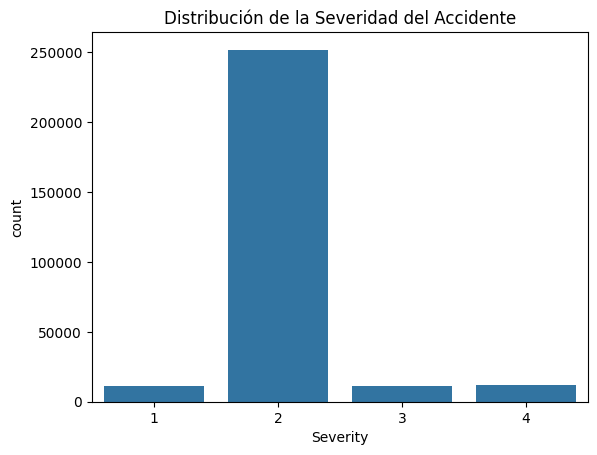

In [24]:
# Distribución de la variable 'Severity'
sns.countplot(x='Severity', data=df)
plt.title('Distribución de la Severidad del Accidente')
plt.show()

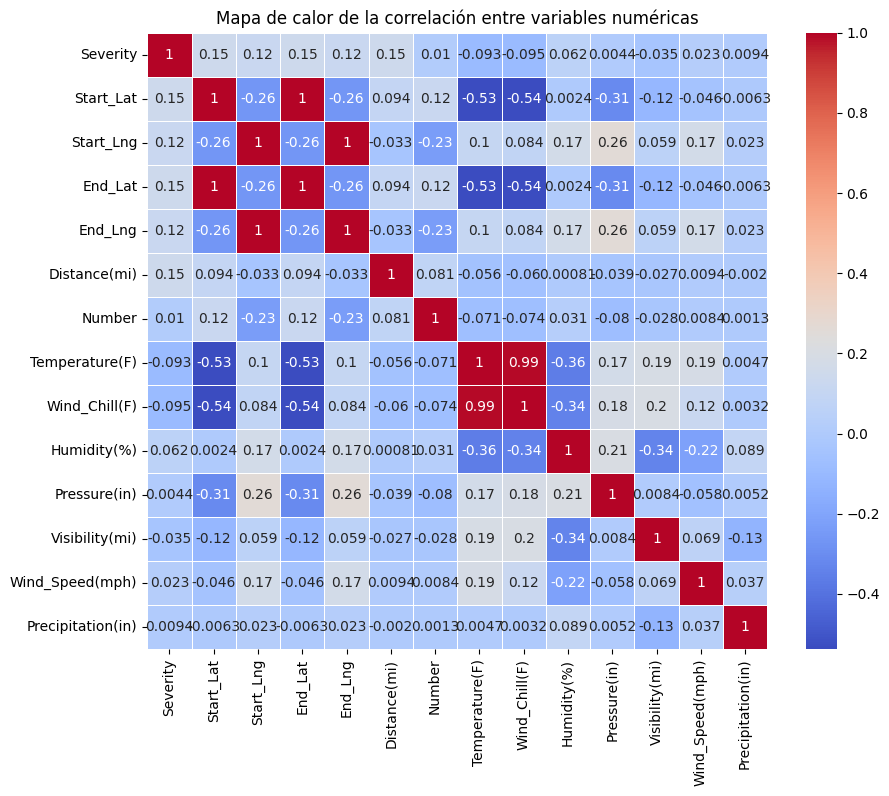

In [25]:
# Seleccionar solo las columnas numéricas
numeric_df = df.select_dtypes(include=['float64', 'int64'])

# Matriz de correlación solo con las columnas numéricas
corr_matrix = numeric_df.corr()
plt.figure(figsize=(10,8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', linewidths=0.5)
plt.title('Mapa de calor de la correlación entre variables numéricas')
plt.show()

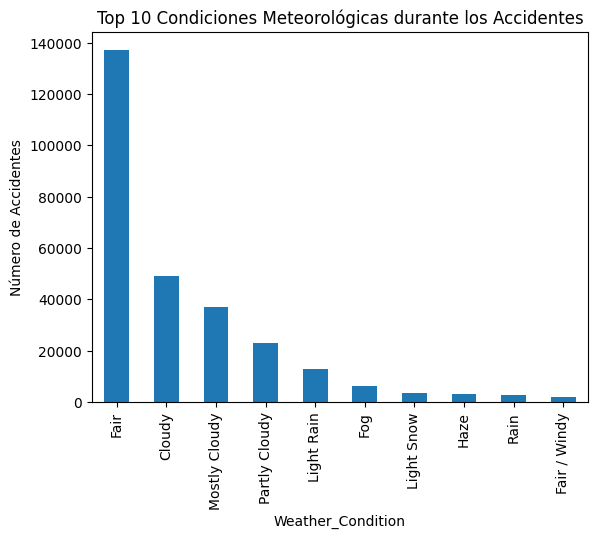

In [26]:
# Ver cuántos accidentes ocurrieron bajo distintas condiciones meteorológicas
weather_counts = df['Weather_Condition'].value_counts().head(10)
weather_counts.plot(kind='bar')
plt.title('Top 10 Condiciones Meteorológicas durante los Accidentes')
plt.ylabel('Número de Accidentes')
plt.show()


## 2. Ingeniería de Características

In [27]:
import numpy as np

# Convertir las fechas especificando el formato correcto
df['Start_Time'] = pd.to_datetime(df['Start_Time'], format='%d-%m-%Y %H:%M', errors='coerce')

# Crear nuevas características
df['Hour'] = df['Start_Time'].dt.hour
df['Day_of_Week'] = df['Start_Time'].dt.dayofweek
df['Is_Weekend'] = df['Start_Time'].dt.dayofweek.isin([5, 6]).astype(int)

print("Nuevas características:")
print(df[['Day_of_Week', 'Is_Weekend', 'Hour']].head())

Nuevas características:
    Day_of_Week  Is_Weekend  Hour
44          1.0           0  18.0
45          1.0           0  18.0
49          2.0           0   6.0
52          2.0           0   8.0
69          2.0           0  12.0


In [28]:
# Crear un índice de riesgo climático y otras características adicionales
adverse_conditions = ['Rain', 'Snow', 'Fog', 'Sleet', 'Hail']
df['Adverse_Weather_Condition'] = df['Weather_Condition'].apply(lambda x: 1 if x in adverse_conditions else 0)
mean_temperature = df['Temperature(F)'].mean()
df['Temperature_Deviation'] = df['Temperature(F)'] - mean_temperature

weather_scores = {
    'Clear': 0,
    'Partly Cloudy': 0,
    'Overcast': 1,
    'Rain': 2,
    'Snow': 3,
    'Fog': 3,
    'Sleet': 3,
    'Hail': 4
}
df['Weather_Score'] = df['Weather_Condition'].map(weather_scores).fillna(0)
df['Climate_Risk_Index'] = df['Temperature_Deviation'] * df['Weather_Score']

# Nuevas características adicionales
df['Road_Condition'] = df['Weather_Condition'].map({'Clear': 0, 'Rain': 1, 'Snow': 2, 'Ice': 3})
df['Distance(km)'] = df['Distance(mi)'] * 1.60934
df['Wind_Speed(m/s)'] = df['Wind_Speed(mph)'] * 0.44704
df['Visibility(m)'] = df['Visibility(mi)'] * 1609.34
df['Pressure(Pa)'] = df['Pressure(in)'] * 3386.39

print("Nuevas características creadas:")
print(df[['Adverse_Weather_Condition', 'Temperature_Deviation', 'Climate_Risk_Index', 
          'Road_Condition', 'Distance(km)', 'Wind_Speed(m/s)', 'Visibility(m)', 
          'Pressure(Pa)']].head())


Nuevas características creadas:
    Adverse_Weather_Condition  Temperature_Deviation  Climate_Risk_Index  \
44                          0             -38.500957                -0.0   
45                          0             -38.500957                -0.0   
49                          0             -41.300957                -0.0   
52                          0             -37.400957                -0.0   
69                          0             -34.300957                -0.0   

    Road_Condition  Distance(km)  Wind_Speed(m/s)  Visibility(m)  Pressure(Pa)  
44             NaN     10.766485         5.677408        3218.68   101083.7415  
45             NaN     10.766485         5.677408        3218.68   101083.7415  
49             NaN      1.940864         8.761984        4023.35   101286.9249  
52             NaN      1.326096         4.649216        1609.34   100541.9191  
69             NaN      0.743515        12.874752        3218.68   100982.1498  


## 3. Selección de Características

In [29]:
from sklearn.feature_selection import mutual_info_regression
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

# Limpieza de datos
df_clean = df.dropna()
numeric_features = df_clean.select_dtypes(include=['float64', 'int64']).columns.tolist()

# Calcular la dependencia mutua entre las características numéricas y 'Severity'
mi_scores = mutual_info_regression(df_clean[numeric_features], df_clean['Severity'])
mi_scores_df = pd.DataFrame({'Feature': numeric_features, 'MI_Score': mi_scores})
mi_scores_df = mi_scores_df.sort_values('MI_Score', ascending=False)

# Mostrar las 5 características más importantes
print("\nTop 5 características más importantes:")
print(mi_scores_df.head())




Top 5 características más importantes:
     Feature  MI_Score
0   Severity  0.567780
4    End_Lng  0.177744
2  Start_Lng  0.176644
1  Start_Lat  0.152786
3    End_Lat  0.145691


In [30]:
# Reducción de dimensionalidad
X_clean = df_clean[numeric_features]
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_clean)

# Aplicar PCA para capturar el 95% de la varianza
pca = PCA(n_components=0.95)
X_pca = pca.fit_transform(X_scaled)

# Resultados de PCA
print(f"\nNúmero de componentes principales: {pca.n_components_}")
print(f"Varianza explicada total: {sum(pca.explained_variance_ratio_):.2f}")



Número de componentes principales: 13
Varianza explicada total: 0.95
